# info

##### モデリング
1. Grid Searchでハイパーパラメーターを求めている
1. 特徴量エンジニアリングを施したデータとそうでないデータなど、複数のデータで複数のモデルを生成している
1. モデルの出力値を適切に加工している
    - 対数変換した目的変数に対する出力をしていれば、逆関数で再現
    - 分類のprobaであれば、分析結果をもとにした閾値を設けて0,1に変換

##### 検証
1. cross validationで未知データに対する精度に近い精度を求めている
1. 線形モデルや決定木を使用し、モデルがどのような特徴を重要として出力しているか確認している
    - ※ロジスティック回帰かSVCか決定木
    - ※係数や分岐を確認する

# init

In [108]:
import os, copy
import numpy as np
import pandas as pd
import uuid
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.externals import joblib

# load

In [110]:
path_doc = "../doc/"

In [111]:
path_data = "../data/"
path_clns = path_data + "clns/"

In [119]:
_dic_data = dict()
for d in os.listdir(path_clns):
    fn = d.split(".")[0]
    _dic_data[fn] = pd.read_csv(path_clns+d, index_col=0)

In [131]:
def get_mart(log=False, tgt=False, oh_tgt_both=False, fam=False, fam_both=False):
    dic_data = copy.deepcopy(_dic_data)
    yname = "survived"
    y = dic_data["y"]
    test_id = y[y[yname].isna()].index
    num = dic_data["num_logz"] if log else dic_data["num_z"]
    
    oh = [v for k, v in dic_data.items() if ("onehot" in k) and not ("family" in k or "parch_sibsp" in k)]
    tgtenc = [v for k, v in dic_data.items() if ("tgt" in k) and not ("family" in k or "parch_sibsp" in k)]
    
    if fam_both:
        oh += [v for k, v in dic_data.items() if ("onehot" in k) and ("family" in k or "parch_sibsp" in k)]
        tgtenc += [v for k, v in dic_data.items() if ("tgt" in k) and ("family" in k or "parch_sibsp" in k)]
    else:
        if fam:
            oh += [v for k, v in dic_data.items() if ("onehot" in k) and ("family" in k)]
            tgtenc += [v for k, v in dic_data.items() if ("tgt" in k) and ("family" in k)]
        else:
            oh += [v for k, v in dic_data.items() if ("onehot" in k) and ("parch_sibsp" in k)]
            tgtenc += [v for k, v in dic_data.items() if ("tgt" in k) and ("parch_sibsp" in k)]
    
    oh = pd.concat(oh, axis=1)
    tgtenc = pd.concat(tgtenc, axis=1)
    
    num.columns = ["num_"+c for c in num.columns]
    oh.columns = ["oh_"+c for c in oh.columns]
    tgtenc.columns = ["tgt_"+c for c in tgtenc.columns]
            
    if oh_tgt_both:
        cat = pd.concat([oh, tgtenc], axis=1)
    else:
        if tgt:
            cat = tgtenc
        else:
            cat = oh
            
    mart = pd.concat([y, num, cat], axis=1)
    train, test = mart[~mart.index.isin(test_id)], mart[mart.index.isin(test_id)]
    train_X, train_y, test_X = train.drop(yname, 1), train[yname], test.drop(yname, 1)
    return train_X, train_y, test_X

# modeling

## LR

In [168]:
def objective(trial):
    flder = "lr_v0/"
    p = "../model/tuning/"+flder
    if not os.path.exists(p):
        os.mkdir(p)
        
    trial_uuid = str(uuid.uuid4())
    trial.set_user_attr("uuid", trial_uuid)

    oh_tgt_both = trial.suggest_int("use_oh_tgt_both", 0, 1)
    fam_both = trial.suggest_int("use_fam_both", 0, 1)
    log = trial.suggest_int("use_log", 0, 1)
    tgt = trial.suggest_int("use_tgt", 0, 1)
    fam = trial.suggest_int("use_fam", 0, 1)
    
    if oh_tgt_both:
        tgt = 1    
    if fam_both:
        fam = 0
    
    param_grid = {
        'C' : trial.suggest_int("C", 1, 20),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        "random_state": 0
    }
    train_X, train_y, test_X = get_mart(log=log, tgt=tgt, oh_tgt_both=oh_tgt_both, fam=fam, fam_both=fam_both)
    
    model = LogisticRegression(**param_grid)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=train_X, y=train_y, cv=kf, scoring="roc_auc")
    auc = scores['test_score'].mean()
    
    # レポーティング
    with open(p+"00.report.csv", mode="a", encoding="utf8") as f:
        r = [trial_uuid, log, tgt, oh_tgt_both, fam, fam_both, *param_grid.values(), auc]
        r = [str(v) for v in r]
        print(",".join(r), file=f)
    
    model.fit(train_X, train_y)
    joblib.dump(model, p+"%s.pkl"%trial_uuid)
    
    return auc

In [170]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2020-03-26 20:01:27,709] Finished trial#0 resulted in value: 0.853886781360576. Current best value is 0.853886781360576 with parameters: {'use_oh_tgt_both': 1, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 1, 'use_fam': 1, 'C': 15, 'penalty': 'l1'}.
[I 2020-03-26 20:01:27,824] Finished trial#1 resulted in value: 0.8676565948997815. Current best value is 0.8676565948997815 with parameters: {'use_oh_tgt_both': 1, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 10, 'penalty': 'l2'}.
[I 2020-03-26 20:01:27,928] Finished trial#2 resulted in value: 0.8672069703725889. Current best value is 0.8676565948997815 with parameters: {'use_oh_tgt_both': 1, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 10, 'penalty': 'l2'}.
[I 2020-03-26 20:01:28,438] Finished trial#3 resulted in value: 0.8551387641010283. Current best value is 0.8676565948997815 with parameters: {'use_oh_tgt_both': 1, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 10, 'penalty

[I 2020-03-26 20:01:37,976] Finished trial#32 resulted in value: 0.8623350859095094. Current best value is 0.8689237740285958 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 5, 'penalty': 'l2'}.
[I 2020-03-26 20:01:38,262] Finished trial#33 resulted in value: 0.8555096336228412. Current best value is 0.8689237740285958 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 5, 'penalty': 'l2'}.
[I 2020-03-26 20:01:38,570] Finished trial#34 resulted in value: 0.8630808181646756. Current best value is 0.8689237740285958 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 5, 'penalty': 'l2'}.
[I 2020-03-26 20:01:38,822] Finished trial#35 resulted in value: 0.8688059188268833. Current best value is 0.8689237740285958 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 5, 'penal

[I 2020-03-26 20:01:51,424] Finished trial#64 resulted in value: 0.8552801903430834. Current best value is 0.8689237740285958 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 5, 'penalty': 'l2'}.
[I 2020-03-26 20:01:51,843] Finished trial#65 resulted in value: 0.8688059188268833. Current best value is 0.8689237740285958 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 5, 'penalty': 'l2'}.
[I 2020-03-26 20:01:52,305] Finished trial#66 resulted in value: 0.8676506050824709. Current best value is 0.8689237740285958 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 5, 'penalty': 'l2'}.
[I 2020-03-26 20:01:52,697] Finished trial#67 resulted in value: 0.8688059188268833. Current best value is 0.8689237740285958 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 5, 'penal

[I 2020-03-26 20:02:06,793] Finished trial#96 resulted in value: 0.8688200059898173. Current best value is 0.8689486206781805 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 3, 'penalty': 'l2'}.
[I 2020-03-26 20:02:07,252] Finished trial#97 resulted in value: 0.8689486206781805. Current best value is 0.8689486206781805 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 3, 'penalty': 'l2'}.
[I 2020-03-26 20:02:07,696] Finished trial#98 resulted in value: 0.8688034230696704. Current best value is 0.8689486206781805 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 3, 'penalty': 'l2'}.
[I 2020-03-26 20:02:08,176] Finished trial#99 resulted in value: 0.865372588821226. Current best value is 0.8689486206781805 with parameters: {'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 3, 'penalt

In [171]:
print(study.best_params)
print(study.best_value)

{'use_oh_tgt_both': 0, 'use_fam_both': 0, 'use_log': 0, 'use_tgt': 0, 'use_fam': 0, 'C': 3, 'penalty': 'l2'}
0.8689486206781805


In [172]:
def objective(trial):
    param_grid = {
        'C' : trial.suggest_uniform("C", 2, 4),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        "random_state": 0
    }
    train_X, train_y, test_X = get_mart()
    
    model = LogisticRegression(**param_grid)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=train_X, y=train_y, cv=kf, scoring="roc_auc")
    auc = scores['test_score'].mean()
    return auc

In [173]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2020-03-26 20:03:09,579] Finished trial#0 resulted in value: 0.868626224307566. Current best value is 0.868626224307566 with parameters: {'C': 3.6195194966144726, 'penalty': 'l2'}.
[I 2020-03-26 20:03:09,705] Finished trial#1 resulted in value: 0.8699770944949142. Current best value is 0.8699770944949142 with parameters: {'C': 2.164049888789962, 'penalty': 'l1'}.
[I 2020-03-26 20:03:09,839] Finished trial#2 resulted in value: 0.8690160615841958. Current best value is 0.8699770944949142 with parameters: {'C': 2.164049888789962, 'penalty': 'l1'}.
[I 2020-03-26 20:03:09,978] Finished trial#3 resulted in value: 0.8690180027286946. Current best value is 0.8699770944949142 with parameters: {'C': 2.164049888789962, 'penalty': 'l1'}.
[I 2020-03-26 20:03:10,103] Finished trial#4 resulted in value: 0.8682157554379776. Current best value is 0.8699770944949142 with parameters: {'C': 2.164049888789962, 'penalty': 'l1'}.
[I 2020-03-26 20:03:10,240] Finished trial#5 resulted in value: 0.8689082448

[I 2020-03-26 20:03:16,180] Finished trial#43 resulted in value: 0.8686311603607202. Current best value is 0.8706061916963386 with parameters: {'C': 2.0201440428234863, 'penalty': 'l1'}.
[I 2020-03-26 20:03:16,345] Finished trial#44 resulted in value: 0.8706031967876833. Current best value is 0.8706061916963386 with parameters: {'C': 2.0201440428234863, 'penalty': 'l1'}.
[I 2020-03-26 20:03:16,507] Finished trial#45 resulted in value: 0.8695489889410226. Current best value is 0.8706061916963386 with parameters: {'C': 2.0201440428234863, 'penalty': 'l1'}.
[I 2020-03-26 20:03:16,662] Finished trial#46 resulted in value: 0.8690180027286946. Current best value is 0.8706061916963386 with parameters: {'C': 2.0201440428234863, 'penalty': 'l1'}.
[I 2020-03-26 20:03:16,826] Finished trial#47 resulted in value: 0.8682148680576354. Current best value is 0.8706061916963386 with parameters: {'C': 2.0201440428234863, 'penalty': 'l1'}.
[I 2020-03-26 20:03:17,004] Finished trial#48 resulted in value: 

[I 2020-03-26 20:03:23,678] Finished trial#86 resulted in value: 0.8685293334664405. Current best value is 0.8707090723547747 with parameters: {'C': 2.0335610638600796, 'penalty': 'l1'}.
[I 2020-03-26 20:03:23,850] Finished trial#87 resulted in value: 0.8690199438731934. Current best value is 0.8707090723547747 with parameters: {'C': 2.0335610638600796, 'penalty': 'l1'}.
[I 2020-03-26 20:03:24,010] Finished trial#88 resulted in value: 0.8695489889410226. Current best value is 0.8707090723547747 with parameters: {'C': 2.0335610638600796, 'penalty': 'l1'}.
[I 2020-03-26 20:03:24,165] Finished trial#89 resulted in value: 0.8690180027286946. Current best value is 0.8707090723547747 with parameters: {'C': 2.0335610638600796, 'penalty': 'l1'}.
[I 2020-03-26 20:03:24,307] Finished trial#90 resulted in value: 0.8689486206781805. Current best value is 0.8707090723547747 with parameters: {'C': 2.0335610638600796, 'penalty': 'l1'}.
[I 2020-03-26 20:03:24,486] Finished trial#91 resulted in value: 

In [174]:
print(study.best_params)
print(study.best_value)

{'C': 2.0335610638600796, 'penalty': 'l1'}
0.8707090723547747


In [175]:
train_X, train_y, test_X = get_mart()
model = LogisticRegression(**study.best_params)
model.fit(train_X, train_y)
joblib.dump(model, "../model/lr_00000.pkl")

submit = test_X.copy()[[]]
submit["pred"] = model.predict_proba(test_X)[:,1]
submit.to_csv("../data/submit/"+"lr_00000.tsv", sep="\t", header=None)
# res: auc = 0.84839

In [176]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")

<BarContainer object of 17 artists>

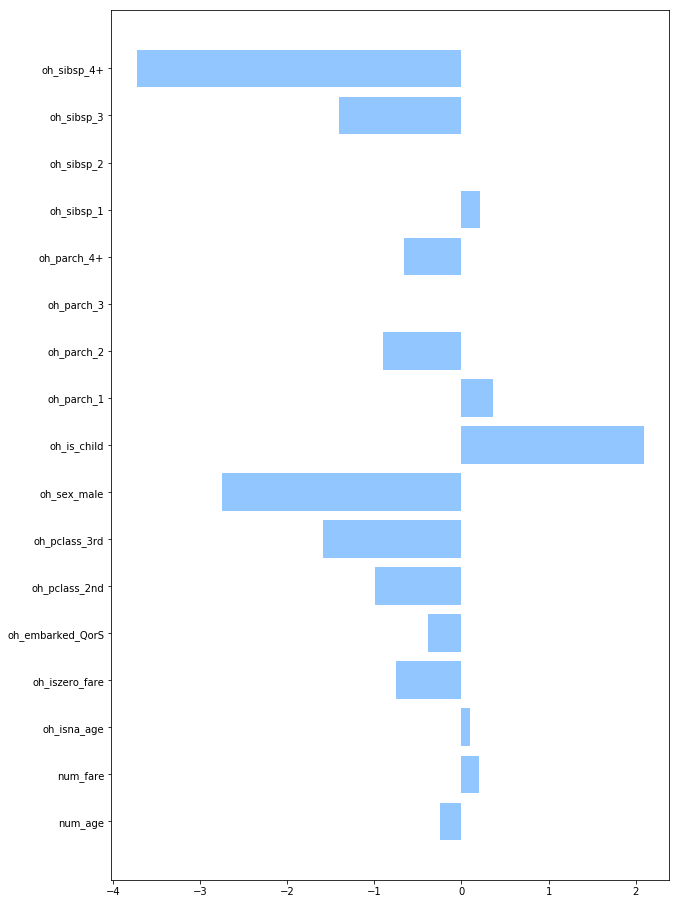

In [177]:
plt.figure(figsize=(10,16))
plt.barh(y=train_X.columns, width=model.coef_[0])

##### チェックポイント1: Grid Searchでハイパーパラメーターを求めている
##### チェックポイント2: 特徴量エンジニアリングを施したデータとそうでないデータなど、複数のデータで複数のモデルを生成している